# **Code de base donné par le sujet:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

## **Dataset**

#### **Load Training Data**
Now, let's load our data using pyH5 package. The training data contains images, landmarks coordinates and labels.

In [2]:
## Loading training data tables from H5py files

## 1. IMAGES
h5f = h5py.File('datasets/data_train_images.h5','r')
train_images = h5f['data_train_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('datasets/data_train_landmarks.h5','r')
train_landmarks = h5f['data_train_landmarks'][:]
h5f.close()

## 3. LABELS
h5f = h5py.File('datasets/data_train_labels.h5','r')
train_labels = h5f['data_train_labels'][:]
h5f.close()


## display the size of the different data tables
print("> Images")
print('Number of training images     :', train_images.shape[0])
print('Number of frames per sequence :', train_images.shape[1])
print('Image shape                   :', train_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', train_landmarks.shape[2])
print('Number of coordinates per landmark :', train_landmarks.shape[-1])


print("\n> Labels")
print('Number of training labels:', train_labels.shape[0])

## Create an expression map to map labels (integer values) to the corresponding expression
expressions = ['Happy','Fear','Surprise','Anger','Disgust','Sad']
expression_mapping = dict(zip(range(len(expressions)), expressions))
print('\n> Expressions map:')
print(expression_mapping)

> Images
Number of training images     : 486
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3

> Labels
Number of training labels: 486

> Expressions map:
{0: 'Happy', 1: 'Fear', 2: 'Surprise', 3: 'Anger', 4: 'Disgust', 5: 'Sad'}


#### **Load Test Data**
For the test data, we only have access to images and landmarks coordinates ! **LABELS ARE NOT AVAILABLE !**
> **Note:** You are supposed to train a model to predict the labels for the testing samples.

In [3]:
## Loading testing data tables from H5py files
## 1. IMAGES
h5f = h5py.File('datasets/data_test_images.h5','r')
test_images = h5f['data_test_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('datasets/data_test_landmarks.h5','r')
test_landmarks = h5f['data_test_landmarks'][:]
h5f.close()

## 3. LABELS
h5f = h5py.File('datasets/data_test_labels.h5','r')
test_labels = h5f['data_test_labels'][:]
h5f.close()

## display the size of the different data tables
print("> Images")
print('Number of testing images      :', test_images.shape[0])
print('Number of frames per sequence :', test_images.shape[1])
print('Image shape                   :', test_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', test_landmarks.shape[2])
print('Number of coordinates per landmark :', test_landmarks.shape[-1])

> Images
Number of testing images      : 206
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3


#### **Visualize Data**

In [4]:
def draw_landmarks_on_face(image, landmarks, draw_tesselation=True, draw_contours=True, draw_irises=True):
    """
    image: np.ndarray of shape (W, H) or (W, H, 3)
    landmarks: np.ndarray of shape (L=478, d=3)
    """

    ## image should be BGR
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    annotated_image = np.copy(image)

    ## Put the landmarks in a normalized list
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
              landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for (x, y, z) in landmarks
            ])

    if draw_tesselation:
        ## FACE MESH TESSELATION
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())

    if draw_contours:
        ## FACE MESH CONTOURS
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())

    if draw_irises:
        ## FAC MESH IRISES
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image


def draw_image_sequence(sequence, dispaly_frames_title=False, sup_title=None):

    """
    sequence: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = len(sequence)

    plt.figure(figsize=(22, 2))
    for i, img in enumerate(sequence, start=1):
        plt.subplot(1, N, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if dispaly_frames_title:
            plt.title(f'frame {i}')
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.show()

def draw_landmarks_on_face_sequence(landmarks_sequence, image_sequence=None, draw_tesselation=True, draw_contours=True, draw_irises=True, title=None):
    """
    landmarks_sequence: list/numpy array of shape (N, L=478, d=3)
    image_sequence[optional]: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = landmarks_sequence.shape[0]

    if image_sequence is not None:
        ## landmarks_sequence & image_sequence should have the same number of samples !
        assert len(image_sequence) == len(landmarks_sequence)
    else:
        image_sequence = np.zeros((N, 200, 200, 3)).astype(np.uint8)

    annotated_images = []
    for i, (img, landamrks) in enumerate(zip(image_sequence, landmarks_sequence), start=1):
        annotated_image = draw_landmarks_on_face(img,
                                                 landamrks,
                                                 draw_tesselation=draw_tesselation,
                                                 draw_contours=draw_contours,
                                                 draw_irises=draw_irises)
        annotated_images.append(annotated_image)

    draw_image_sequence(annotated_images, sup_title=title)

Sequence label: Anger


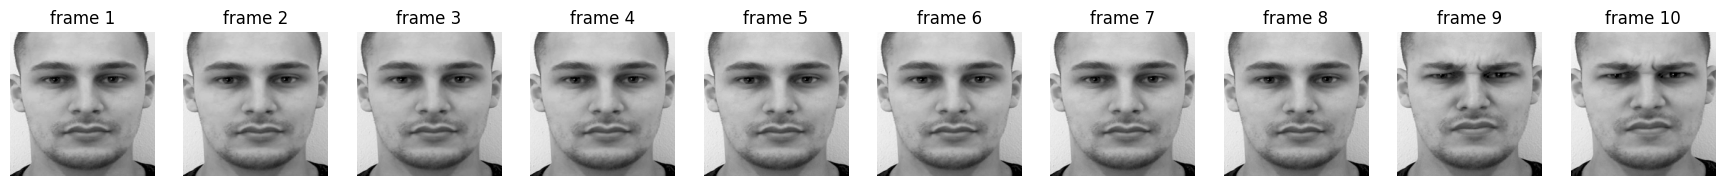

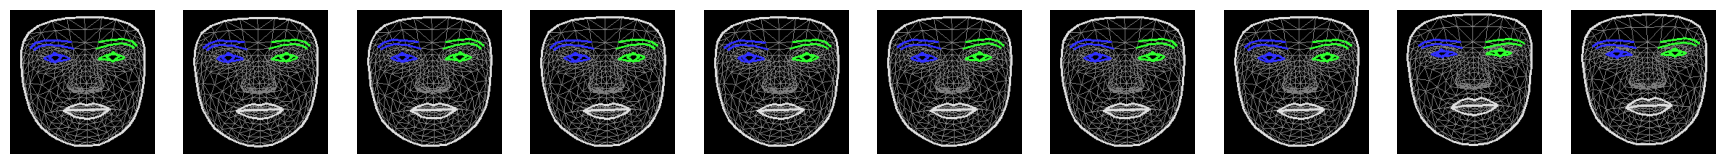

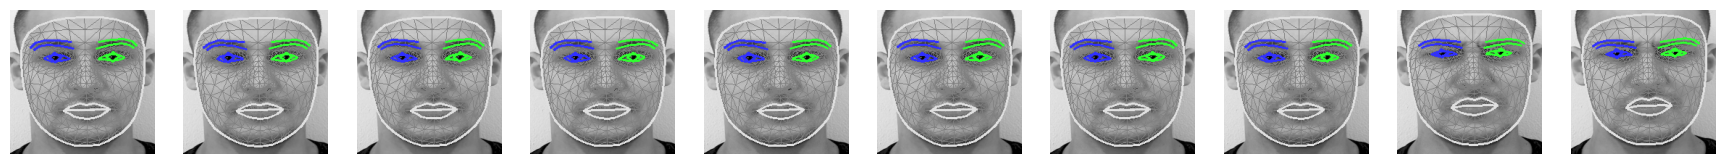

In [5]:
## display a random sequence
idx = np.random.randint(len(train_landmarks))
img_sequence = train_images[idx]
landmarks_sequence = train_landmarks[idx]
print(f'Sequence label: {expression_mapping[train_labels[idx]]}')

## display original sequence
draw_image_sequence(img_sequence, dispaly_frames_title=True)

## draw original landmarks
draw_landmarks_on_face_sequence(landmarks_sequence)

## draw images and landmarks
draw_landmarks_on_face_sequence(landmarks_sequence, img_sequence)

You can also use the following function to extract differents meshes from the face landmarks including: TESSELATION (in gray), CONTOURS (in white, blue and green) and IRISES in (green and blue).

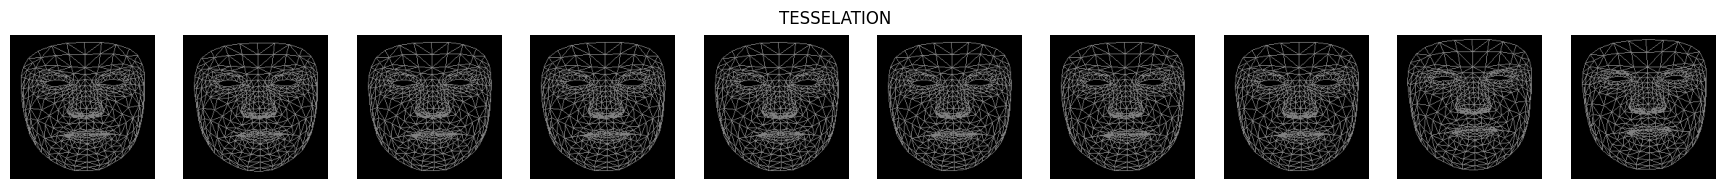

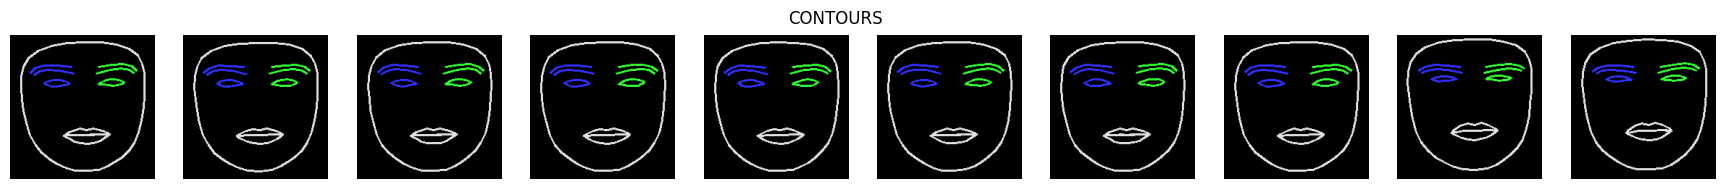

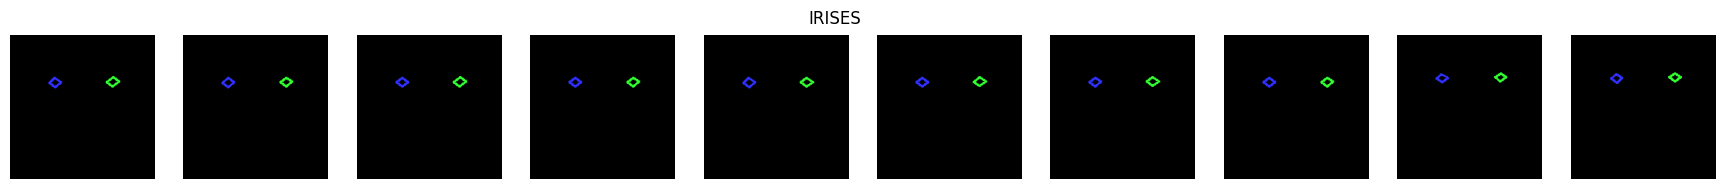

In [6]:
## draw TESSELATION ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=True, draw_contours=False, draw_irises=False, title='TESSELATION')
## draw CONTOURS ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=True, draw_irises=False, title='CONTOURS')
## draw IRISES ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=False, draw_irises=True, title='IRISES')

In [7]:
def extract_tesselation_landmarks(landmarks):
    """Returns the TESSELATION LANDMARKS"""
    ## get tesselation landmarks indices
    TESSELATION_INDICES = list(mp.solutions.face_mesh.FACEMESH_TESSELATION)
    TESSELATION_INDICES = np.unique(TESSELATION_INDICES)
    ## extract landmarks
    TESSELATION_landmarks = landmarks[TESSELATION_INDICES]
    return TESSELATION_landmarks

def extract_contours_landmarks(landmarks):
    """Returns the CONTOURS LANDMARKS"""
    ## get contours landmarks indices
    CONTOURS_INDICES = list(mp.solutions.face_mesh.FACEMESH_CONTOURS)
    CONTOURS_INDICES = np.unique(CONTOURS_INDICES)
    ## extract landmarks
    contours_landmarks = landmarks[CONTOURS_INDICES]
    return contours_landmarks

def extract_irises_landmarks(landmarks):
    """Returns the IRISES LANDMARKS"""
    ## get irises landmarks indices
    IRISES_INDICES = list(mp.solutions.face_mesh.FACEMESH_IRISES)
    IRISES_INDICES = np.unique(IRISES_INDICES)
    ## extract landmarks
    irises_landmarks = landmarks[IRISES_INDICES]
    return irises_landmarks

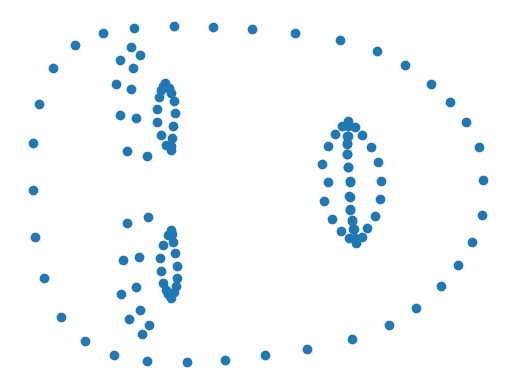

In [8]:
## an example: extracting the contours landmarks
contours_landmarks = extract_contours_landmarks(landmarks_sequence[-1])
plt.scatter(contours_landmarks[:, 1], contours_landmarks[:, 0])
plt.axis('off')
plt.show()

---

# **Code d'Henri:**

Travail sur les landmarks, visualisation des données en 3D, puis simplfication des données pour des entraînements plus simple.

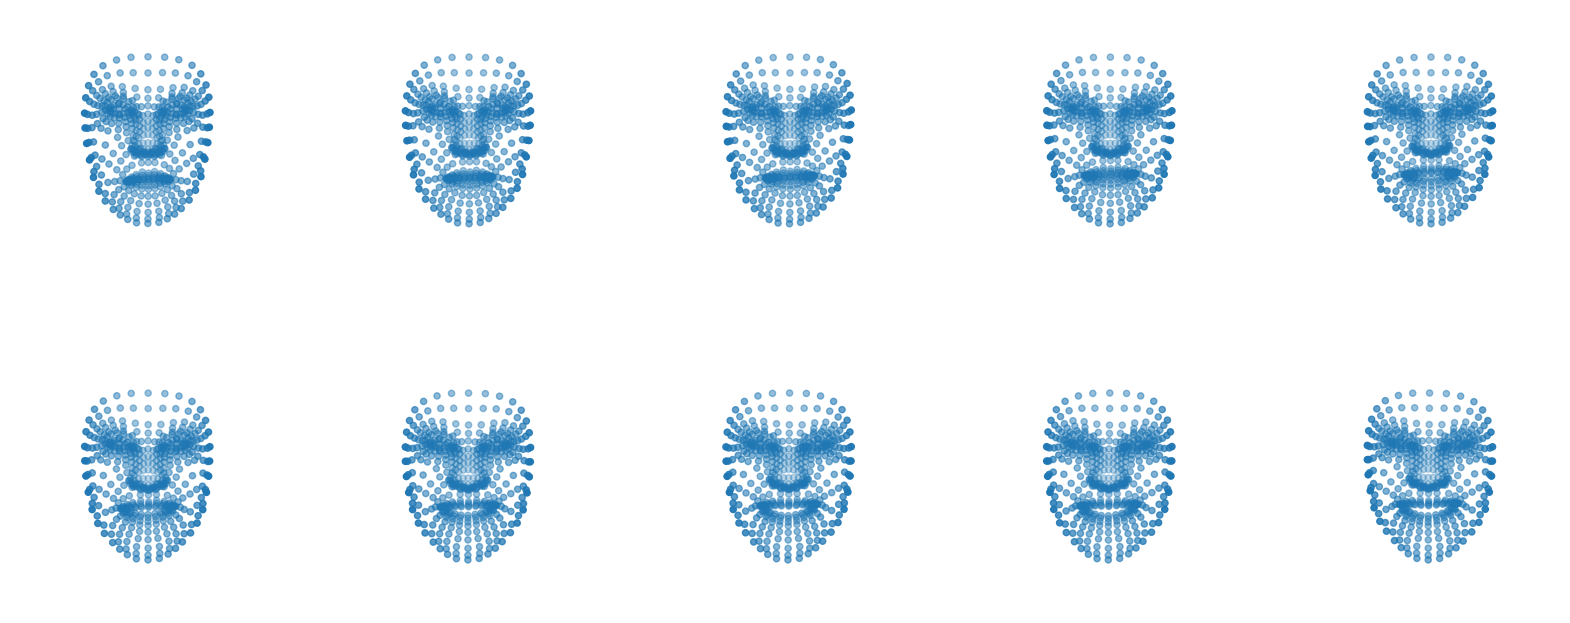

In [9]:
def plot_landmark_sequence(image_index):
    """
    Display the 3D representation of landmark for the full sequence
    """

    fig = plt.figure(figsize=(20, 8))

    # For each image of the sequence
    for i in range(len(train_landmarks[image_index])):
        # Add the subplot
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        ax.set_box_aspect((1, 1, 1.4))
        ax.axis('off')
        ax.view_init(0, 90, 0)
        # Scatter the 3 axis
        ax.scatter(train_landmarks[image_index][i][:,0], train_landmarks[image_index][i][:,2], -train_landmarks[image_index][i][:,1])

    plt.show()

# Example
plot_landmark_sequence(17)

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def build_mlp(train_features, test_features, train_targets, test_targets, num_neurons=2):
    """
    Train a Perceptron and print the accuracy of the model
    """
    classifier = MLPClassifier(hidden_layer_sizes=num_neurons, max_iter=500, activation='relu', solver='sgd', random_state=762, learning_rate='invscaling')
    classifier.fit(train_features, train_targets)

    predictions = classifier.predict(test_features)
    score = accuracy_score(test_targets, predictions)
    print(f"Perceptron accuracy: {score}")

Deux façons de simplifier les données:
* Soit on regarde le max - min des coordonées en y sur l'intégralité d'une séquence. Exemple, si la personne sourri, le max-min vaudra une "grande" valeur positive. Les valeurs proches de zéros représentent donc les points n'ayant presque pas bougé.
* Sinon, on peut également ne garder que la dernière image (celle sur laquelle se trouve l'expression) et on ne garde que les coordonées en y qui sont les plus représentatives de l'expression.

Dans les deux cas, afin de simplifier la donnée, il est possible de ne garder que le contour car c'est ce qui représente le mieux l'expression du visage, de plus, il est possible de garder les deux axes (x et y) en mettant les valeurs les unes après les autres.

In [11]:
def simplify_landmarks(landmarks, only_contour=True, with_x_axis=False):
    """
    Simplify a set of landmarks by extracting the contour and transforming the data
    """
    NUMBER_OF_SEQUENCES = 10
    NUMBER_OF_CONTOUR_POINTS = 128
    # Will select landmarks.shape[2] if only_contour == False, or 128 else
    SHAPE_TO_CHOOSE = [landmarks.shape[2], NUMBER_OF_CONTOUR_POINTS]

    # Creates the array with double length if we want both axis
    simplified_landmarks = np.zeros((landmarks.shape[0], (SHAPE_TO_CHOOSE[only_contour] * (2 ** with_x_axis))))

    for image in range(len(simplified_landmarks)):
        # Extract the contours of each sequence        
        transform = np.zeros((2, NUMBER_OF_SEQUENCES, SHAPE_TO_CHOOSE[only_contour]))

        for sequence in range(len(landmarks[image])):
            # If we want the contour, we extract the values of the contour, else we just extract the standard points of the sequence
            if only_contour:
                contours = extract_contours_landmarks(landmarks[image][sequence])
                transform[0][sequence] -= contours[:, 0]
                transform[1][sequence] -= contours[:, 1]
            else:
                transform[0][sequence] -= landmarks[image][sequence][:, 0]
                transform[1][sequence] -= landmarks[image][sequence][:, 1]

        # transform the trajectory of each point with the (max - min) value, meaning the distance travelled
        for point in range(transform.shape[2]):
            column = transform[1][:, point]
            simplified_landmarks[image][point] = round((np.max(column) - np.min(column)) * 100, 5)
        # If we have x axis, we want to fill the second part of the array with all the x values
        if with_x_axis:
            for point in range(transform.shape[2]):
                column = transform[0][:, point]
                simplified_landmarks[image][point + transform.shape[2]] = round((np.max(column) - np.min(column)) * 100, 5)

    return simplified_landmarks

In [12]:
def round_to_zero(landmarks):
    """
    For every value below 1, the value is rounded to 0 to simplify the data
    """
    for i in range(landmarks.shape[0]):
        for j in range(landmarks.shape[1]):
            if landmarks[i][j] < 1: landmarks[i][j] = 0

In [13]:
def keep_last_image(landmarks, only_contour=True, with_x_axis=False):
    """
    Transform the landmarks to keep only the landmarks of the last sequence for each image
    """
    LAST_SEQUENCE = 9
    NUMBER_OF_CONTOUR_POINTS = 128
    # Will select landmarks.shape[2] if only_contour == False, or 128 else
    SHAPE_TO_CHOOSE = [landmarks.shape[2], NUMBER_OF_CONTOUR_POINTS]

    # Creates the array with double length if we want both axis
    simplified_landmarks = np.zeros((landmarks.shape[0], (SHAPE_TO_CHOOSE[only_contour] * (2 ** with_x_axis))))

    # We keep only the last sequence for every image
    for image in range(simplified_landmarks.shape[0]):
        contour = extract_contours_landmarks(landmarks[image][LAST_SEQUENCE])
        
        # Fill the array with all the points
        for point in range(simplified_landmarks.shape[1]):
            if only_contour:
                if with_x_axis:
                    # Will be 0 for the first half and 1 for the second
                    position_x_or_y = int(point >= contour.shape[0])
                    simplified_landmarks[image][point] = contour[point % contour.shape[0]][position_x_or_y]

                else:
                    simplified_landmarks[image][point] = contour[point][1]
            
            else:
                if with_x_axis:
                    # Will be 0 for the first half and 1 for the second
                    position_x_or_y = int(point >= landmarks.shape[2])
                    simplified_landmarks[image][point] = landmarks[image][LAST_SEQUENCE][point % landmarks.shape[2]][position_x_or_y]

                else:
                    simplified_landmarks[image][point] = landmarks[image][LAST_SEQUENCE][point][1]

    return simplified_landmarks

In [14]:
def get_simplified_landmarks(train, test, choice, round_to_zero=True, only_contour=True, with_x_axis=False):
    if choice == "min-max":
        # Simplify both train and test landmarks by using max - min
        train_simplified = simplify_landmarks(train, only_contour=only_contour, with_x_axis=with_x_axis)
        test_simplified = simplify_landmarks(test, only_contour=only_contour, with_x_axis=with_x_axis)
        print("Successfully simplified the landmarks")

        if round_to_zero:
            # Round every value below 1 to exactly 0 to simplify even more the data
            round_to_zero(train_simplified)
            round_to_zero(test_simplified)
            print("Successfully rounded all values below 1 to 0")

    elif choice == "last-image":
        # Simplify the data by keeping only the last image of each sequence
        train_simplified = keep_last_image(train, only_contour=only_contour, with_x_axis=with_x_axis)
        test_simplified = keep_last_image(test, only_contour=only_contour, with_x_axis=with_x_axis)
        print("Successfully troncated data to keep only the last image of each sequence")
    
    else:
        print("Please select an existing choice")
        return

    return train_simplified, test_simplified

train_simplified_landmarks, test_simplified_landmarks = get_simplified_landmarks(train_landmarks, test_landmarks, "min-max", round_to_zero=False)

Successfully simplified the landmarks


Deux modèles essayés:
* Le RandomForest avait une *accuracy* autour de 75% en moyenne, mais n'a pas dépassé 52% lors des prédictions.
* Le Boosting quant à lui est monté jusqu'à 98% d'accuracy, mais les deux fichiers de prédictions ont obtenu un score de 0...

In [15]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange

# Split the data
X_landmarks, X_landmarks_test, Y_train, Y_test = train_test_split(train_simplified_landmarks, train_labels)


# build_mlp(X_landmarks, X_landmarks_test, Y_train, Y_test) # You can activate the perceptron but the accuracy is bad

score_rf, iteration = 0, 0
target = 0.80
max_iteration = 10

# Train a RandomForest until it reaches the target accuracy
for iteration in trange(max_iteration):
    rf = RandomForestClassifier(criterion='gini', max_features=0.5, class_weight='balanced')
    rf.fit(X_landmarks, Y_train)
    score_rf = accuracy_score(Y_test, rf.predict(X_landmarks_test))

    if score_rf > target:
        print(f"Random Forest accuracy: {score_rf}")
        break

else:
    print(f"Failed to get over {target} accuracy, stuck with: {score_rf}")

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Failed to get over 0.8 accuracy, stuck with: 0.7786885245901639


In [16]:
import csv
import datetime

def write_predictions(predictions):
    """
    Write the predictions in the right format in a file with name 'predictions_date_hour'
    """
    file_name = f"predictions/predictions_{datetime.datetime.now().strftime('%Y-%M-%d_%Hh%M')}.csv"

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Header
        writer.writerow(["Id", "Expression"])

        for i, predicted in enumerate(predictions):
            writer.writerow([i, predicted])

    print(f"Successfully wrote the predictions in file {file_name} with {round(score * 100)}% of accuracy on the model")

# write_predictions(rf.predict(test_simplified_landmarks))

In [17]:
import xgboost
from ray import train

# Training method
def train_boost_genre(config):
    # Split the data
    X = train_simplified_landmarks
    # X = train_landmarks_2D
    y = train_labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

    # Creates the XGBoost model
    train_set = xgboost.DMatrix(X_train, label=y_train)
    test_set = xgboost.DMatrix(X_test, label=y_test)
    results = {}

    booster = xgboost.train(
        config['params'],
        train_set,
        evals=[(test_set, "eval")],
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=config['early_stopping_rounds'],
        xgb_model=config['model']
    )

    # Predict the genre and display the accuracy
    y_pred = booster.predict(test_set)
    accuracy = accuracy_score(y_test, y_pred)

    train.report({"accuracy": accuracy, "done": True, "merror": results['eval']['merror'][-1],
                  "mlogloss": results['eval']['mlogloss'][-1], "model": booster})

    return booster, accuracy, results

In [18]:
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray import tune

# Tries a lot of configuration by tuning the parameters
b = None
config = {
    'params': {
        "objective": "multi:softmax",
        "eval_metric": ["merror", "mlogloss"],
        "max_depth": tune.randint(1, 200),
        "min_child_weight": tune.uniform(0, 20),
        "subsample": tune.uniform(0.2, 1.0),
        "eta": tune.loguniform(1e-7, 1e-1),
        "num_class": len(expressions),
        "tree_method": tune.choice(['auto', 'exact', 'approx', 'hist'])
    },
    "early_stopping_rounds": tune.randint(10, 10000),
    "model": b
}
scheduler = ASHAScheduler(
    max_t=50, grace_period=5, reduction_factor=2
)
tuner = tune.Tuner(
    train_boost_genre,
    tune_config=tune.TuneConfig(
        metric="merror",
        mode="min",
        num_samples=100,
        scheduler=scheduler
    ),
    param_space=config,
)

# Find the best config on the accuracy parameter
results = tuner.fit()
best_trial = results.get_best_result("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation accuracy: {best_trial.metrics['accuracy']:.4f}")
print(f"Best trial final validation error: {best_trial.metrics['merror']:.4f}")
print(f"Best trial final validation logloss: {best_trial.metrics['mlogloss']:.4f}")
print(best_trial)

(bundle_reservation_check_func pid=18352) Traceback (most recent call last):
(bundle_reservation_check_func pid=18352)   File "python\ray\_raylet.pyx", line 2102, in ray._raylet.execute_task_with_cancellation_handler
(bundle_reservation_check_func pid=18352)   File "python\ray\_raylet.pyx", line 1756, in ray._raylet.execute_task
(bundle_reservation_check_func pid=18352)   File "python\ray\_raylet.pyx", line 1757, in ray._raylet.execute_task
(bundle_reservation_check_func pid=18352)   File "python\ray\_raylet.pyx", line 1760, in ray._raylet.execute_task
(bundle_reservation_check_func pid=18352)   File "python\ray\_raylet.pyx", line 1788, in ray._raylet.execute_task
(bundle_reservation_check_func pid=18352)   File "c:\Users\Utilisateur\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\_private\utils.py", line 1852, in __exit__
(bundle_reservation_check_func pid=18352)     raise KeyboardInterrupt
(bundle_reservation_check_func pid=18352) KeyboardInterrupt
(bundle_reservation_c

Best trial config: {'params': {'objective': 'multi:softmax', 'eval_metric': ['merror', 'mlogloss'], 'max_depth': 35, 'min_child_weight': 0.26491295691033256, 'subsample': 0.7123390235321658, 'eta': 0.01608493708506916, 'num_class': 6, 'tree_method': 'auto'}, 'early_stopping_rounds': 5153, 'model': None}
Best trial final validation accuracy: 0.7959
Best trial final validation error: 0.2041
Best trial final validation logloss: 1.5760
Result(
  metrics={'accuracy': 0.7959183673469388, 'merror': 0.20408163265306123, 'mlogloss': 1.5759650420169442, 'model': <xgboost.core.Booster object at 0x000001E02234B880>},
  path='C:/Users/Utilisateur/ray_results/train_boost_genre_2024-02-01_11-20-03/train_boost_genre_79de7_00035_35_early_stopping_rounds=5153,eta=0.0161,max_depth=35,min_child_weight=0.2649,subsample=0.7123,tree__2024-02-01_11-20-29',
  filesystem='local',
  checkpoint=None
)


c:\Users\Utilisateur\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\train\_internal\session.py:638: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


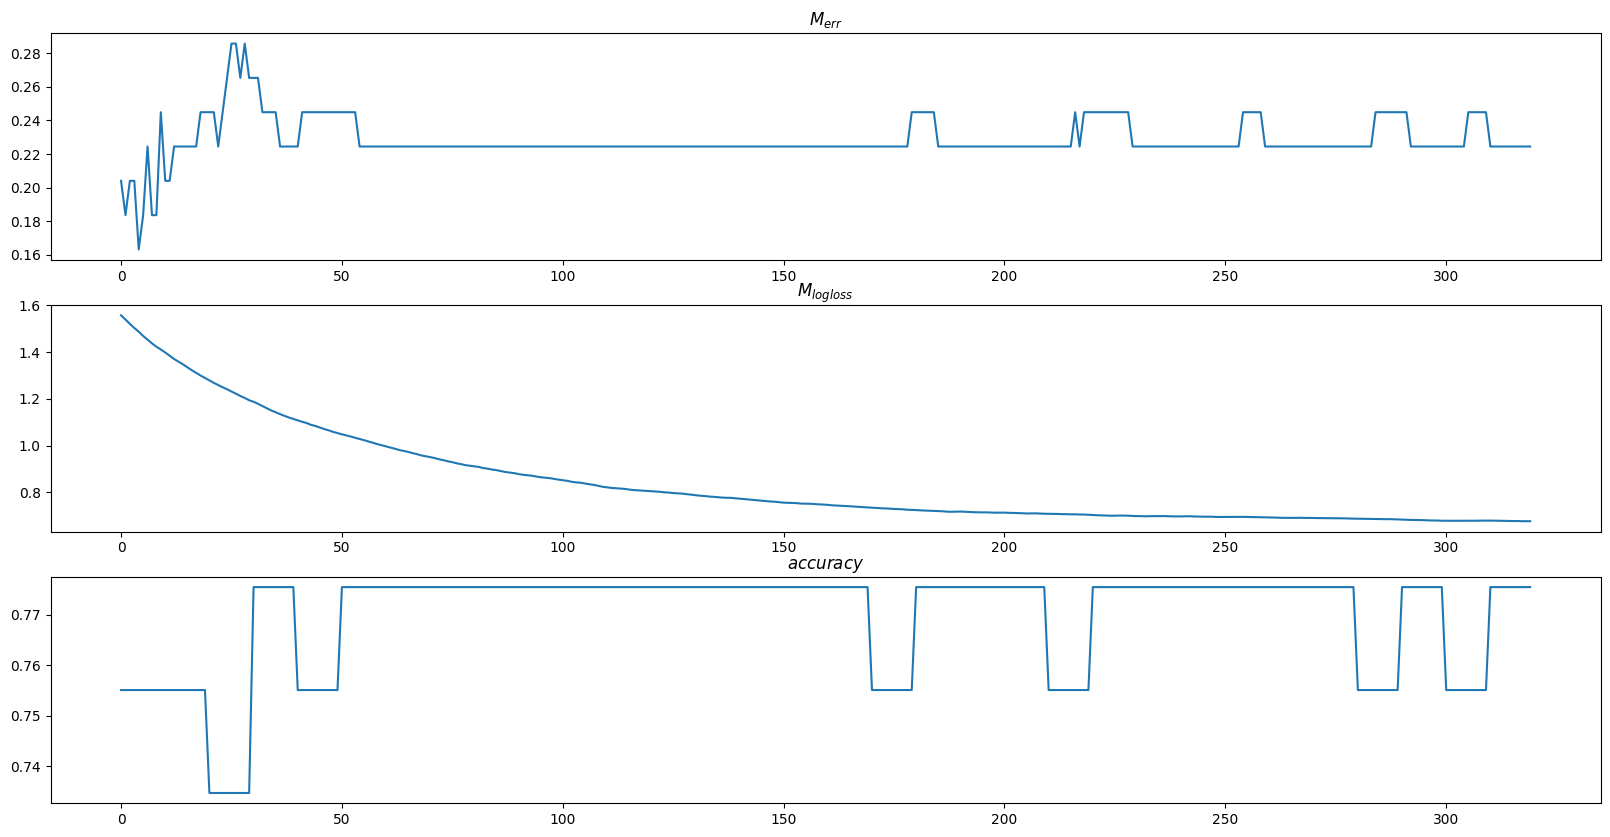

Best accuracy: 0.7755102040816326


In [19]:
import matplotlib.pyplot as plt

b = best_trial.metrics['model'] if best_trial is not None else None
merrs = []
mloglosss = []
accs = []

# Train a few times the same model and save the error, log loss and accuracy
for _ in range(32):
    b, acc, res = train_boost_genre({
        'params': best_trial.config['params'],
        "early_stopping_rounds": best_trial.config['early_stopping_rounds'],
        'model': b
    })
    merrs.extend(res['eval']['merror'])
    mloglosss.extend(res['eval']['mlogloss'])
    accs.extend([acc] * len(res['eval']['mlogloss']))

# Plot the 3 curves and find the best accuracy
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(3, 1, 1)
plt.plot(merrs)
plt.title('$M_{err}$')
fig.add_subplot(3, 1, 2)
plt.plot(mloglosss)
plt.title('$M_{logloss}$')
fig.add_subplot(3, 1, 3)
plt.plot(accs)
plt.title('$accuracy$')
plt.show()

print(f"Best accuracy: {max(accs)}")

In [20]:
predictions = b.predict(xgboost.DMatrix(X_landmarks_test))
score_boosting = accuracy_score(Y_test, predictions)
print(score_boosting)

# write_predictions(b.predict(xgboost.DMatrix(test_simplified_landmarks)))

0.9836065573770492


Quelques vérifications et analyses ont été faites entre les différentes prédictions que nous avions faites, ainsi que sur les données labellisées à la main, étant donné les résultats étranges que nous avions obtenu.

In [21]:
import pandas

def count_same_answers_csv(file_1, file_2):
    dataset_1 = pandas.read_csv(file_1)
    dataset_2 = pandas.read_csv(file_2)

    count = 0

    for i in range(len(dataset_1["Expression"])):
        if dataset_1["Expression"][i] == dataset_2["Expression"][i]:
            count += 1

    print(f"The files {file_1} and {file_2} have {count} answers in common ({round(100 * count/len(dataset_1['Expression']))}%)")


count_same_answers_csv("predictions/predictions_2024-44-31_09h44.csv", "tests/henri_52459.csv")
count_same_answers_csv("predictions/predictions_2024-44-31_09h44.csv", "tests/pierre_52459.csv")
count_same_answers_csv("predictions/predictions_2024-44-31_09h44.csv", "tests/henri_0.csv")

The files predictions/predictions_2024-44-31_09h44.csv and tests/henri_52459.csv have 126 answers in common (61%)
The files predictions/predictions_2024-44-31_09h44.csv and tests/pierre_52459.csv have 96 answers in common (47%)
The files predictions/predictions_2024-44-31_09h44.csv and tests/henri_0.csv have 172 answers in common (83%)


In [22]:
print(f"Accuracy on RandomForest (training accuracy: {round(100 * score_rf)}%) for the test file: {accuracy_score(test_labels, rf.predict(test_simplified_landmarks))}")
print(f"Accuracy on Boosting (training accuracy: {round(100 * score_boosting)}%) for the test file: {accuracy_score(test_labels, b.predict(xgboost.DMatrix(test_simplified_landmarks)))}")

Accuracy on RandomForest (training accuracy: 78%) for the test file: 0.5048543689320388
Accuracy on Boosting (training accuracy: 98%) for the test file: 0.5388349514563107


---

# **Code de Pierre**

Travail sur les landmarks et sur les images. La majeure partie du temps à été passée à implémenter différents modèles de réseaux de neuronnes. Pour les images, le premier modèle est un modèle ressemblant à du resnet, le deuxième est du resnet + LSTM.

In [ ]:
import os
import tempfile
import time

import h5py
import numpy as np
import ray
import torch
from ray.air import session
from ray.train import Checkpoint
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


BASE_PATH = os.getcwd()

h5f = h5py.File(f'{BASE_PATH}/datasets/data_train_landmarks.h5', 'r')
train_landmarks = h5f['data_train_landmarks'][:]
train_landmarks = np.array([train_landmarks[i][-1] for i in range(len(train_landmarks))])
h5f.close()

h5f = h5py.File(f'{BASE_PATH}/datasets/data_train_labels.h5', 'r')
train_labels = h5f['data_train_labels'][:]
h5f.close()

def load_dataset(batch_size, device):
    X_train, X_valid, y_train, y_valid = train_test_split(train_landmarks,
                                                          train_labels, test_size=0.2,
                                                          random_state=12345)
    TX_train = torch.tensor(X_train, dtype=torch.float).to(device)
    Ty_train = torch.tensor(y_train, dtype=torch.long).to(device)

    TX_test = torch.tensor(X_valid, dtype=torch.float).to(device)
    Ty_test = torch.tensor(y_valid, dtype=torch.long).to(device)

    t_dataset_train = TensorDataset(TX_train, Ty_train)
    t_dataset_test = TensorDataset(TX_test, Ty_test)

    train_batch = DataLoader(t_dataset_train, batch_size=batch_size, shuffle=True)
    validation_batch = DataLoader(t_dataset_test, batch_size=batch_size, shuffle=True)

    return train_batch, validation_batch

In [ ]:
def train_model(config):
    # print(config)
    chk = None
    if 'checkpoint' in config:
        chk = config['checkpoint']
        config = chk['config']
    # Initialisation
    running_losses = []
    validation_losses = []
    accs = []

    device = config['device']
    SHOW_BAR = config['show_bar']

    model = config['model'](convs=config['convs'], nns=config['nns']).to(device)

    loss_fn = config['loss_fn']()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    # We load the training at a specific checkpoint if wanted
    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    if chk is not None:
        model.load_state_dict(chk['model_state_dict'])
        optimizer.load_state_dict(chk['optimizer_state_dict'])
        start_epoch = chk['epoch']

    # Get the DataLoaders
    train_batch, validation_batch = load_dataset(batch_size=config['batch_size'], device=device)

    # Used for a better display using tqdm
    MAX_EPOCH = config['max_epoch']
    if SHOW_BAR:
        bar = tqdm(total=MAX_EPOCH, initial=start_epoch)

    # Training for every epoch
    try:
        for epoch in range(start_epoch, MAX_EPOCH):
            running_loss = 0.
            model.train()

            # Computes the running loss during training
            for _, data in enumerate(train_batch):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

            validation_loss = 0.
            accuracy = 0
            validation_total = 0
            model.eval()

            # Test the model and evaluates the performances
            for _, data in enumerate(validation_batch):
                # No computation of the gradient for better performances
                with torch.no_grad():
                    inputs, labels = data
                    outputs = model(inputs).squeeze()
                    # print(torch.argmax(outputs, dim=1), labels.squeeze())
                    loss = loss_fn(outputs, labels.squeeze())
                    validation_loss += loss.item()
                    validation_total += labels.size(0)
                    accuracy += (torch.argmax(outputs, dim=1) == labels).sum().item()

            running_loss /= len(train_batch)
            validation_loss /= len(validation_batch)
            running_losses.append(running_loss)
            validation_losses.append(validation_loss)
            accs.append(accuracy / validation_total)

            # Creates a checkpoint if necessary
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                # torch.save((model.state_dict(), optimizer.state_dict()), path)
                # checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                ray.train.report({"loss": validation_loss, "accuracy": accuracy / validation_total},
                                 )

            # Handles a proper display
            if SHOW_BAR:
                bar.update(1)
                bar.set_postfix(
                    str=f"Running loss: {running_loss:.3f} - Validation loss: {validation_loss:.3f} | Accuracy: {accuracy / validation_total:.3f}.")
    except KeyboardInterrupt:
        print(f"Saving model at {epoch} steps.")
    if SHOW_BAR:
        bar.close()

    return running_losses, validation_losses, accs, epoch, model, optimizer


In [ ]:
class Model1(torch.nn.Module):

    def __init__(self, convs=[20, 20], lstm_layers=2, nns=[(20, 0.5)]):
        super().__init__()
        # self.lstm = torch.nn.LSTM(input_size=1434, hidden_size=hidden, num_layers=lstm_layers, batch_first=True)
        self.conv = torch.nn.Sequential(
            torch.nn.Conv1d(478, convs[0], kernel_size=2),
            torch.nn.BatchNorm1d(convs[0]),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(2),

            torch.nn.Conv1d(convs[0], convs[1], kernel_size=1),
            torch.nn.BatchNorm1d(convs[1]),
            torch.nn.ReLU(),
            # torch.nn.MaxPool1d(2),
        )
        self.linear_after = torch.nn.Sequential(torch.nn.Linear(convs[-1], nns[0][0]), torch.nn.ReLU())
        self.stack = torch.nn.Sequential(*np.array([
            [torch.nn.Linear(nns[i][0], nns[i + 1][0]), torch.nn.ReLU(), torch.nn.Dropout(nns[i][1])] for i in
            range(len(nns) - 1)
        ]).flatten())
        self.pred = torch.nn.Linear(nns[-1][0], 6)

    def forward(self, x: torch.Tensor):
        # print(x.shape, "LSTM")
        # x, (h_t) = self.lstm(x)
        # print(x)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)
        # x = torch.sum(x, dim=1)
        # print(x.shape)
        x = torch.nn.Flatten()(x)
        # print(x.shape)

        x = self.linear_after(x)
        for l in self.stack:
            # print(x.shape, l)
            x = l(x)
        # print(x.shape)
        return self.pred(x)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

def ttrain():
    ray.init()
    config = {
        "convs": [tune.choice(np.arange(8, 512, 1)) for _ in range(2)],
        # "lstm_layers": tune.choice(np.arange(1, 20, 1)),
        "nns": [(tune.choice(np.arange(1, 400, 1)), tune.uniform(0.3, 0.6)) for _ in range(20)],
        "lr": 100e-6,
        "batch_size": tune.choice([16, 32, 64, 128]),
        'model': tune.choice([Model1]),
        'loss_fn': torch.nn.CrossEntropyLoss,
        'loader': load_dataset,
        'max_epoch': 1000,
        'device': device,
        'show_bar': False,
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=200,
        grace_period=20,
        reduction_factor=4,
    )

    # Handles the results
    result = tune.run(
        train_model,
        # resources_per_trial=tune.PlacementGroupFactory(
        #     [{'CPU': 1}, {'GPU': 1}] * 4
        # ),
        resources_per_trial={'CPU': 3, 'GPU': 1},
        config=config,
        num_samples=20,
        scheduler=scheduler,
        progress_reporter=CLIReporter(max_progress_rows=10, print_intermediate_tables=False)
    )

    # Find the best config on the accuracy parameter
    best_trial = result.get_best_trial("accuracy", "max", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
    ray.shutdown()

In [ ]:
def mcpred():
    files = [os.path.join('models', f) for f in os.listdir('models')]  # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x))
    checkpoint = torch.load(f'{files[-1]}')

    model: torch.nn.Module = checkpoint['config']['model'](hidden=int(checkpoint['config']['hidden']),
                                                           lstm_layers=checkpoint['config']['lstm_layers'],
                                                           nns=checkpoint['config']['nns']).to(
        device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    BASE_PATH = os.getcwd()
    h5f = h5py.File(f'{BASE_PATH}/datasets/data_test_landmarks.h5', 'r')
    test_landmarks = h5f['data_test_landmarks'][:]
    test_landmarks = np.array([test_landmarks[i][-1] for i in range(len(test_landmarks))])
    h5f.close()
    TX_test = torch.tensor(test_landmarks, dtype=torch.float).to(device)
    result = torch.argmax(model(TX_test), dim=1)
    print(result)
    f = open('datasets/submission.csv', 'w')
    f.write("Id,Expression\n")
    for i, expr in enumerate(result):
        f.write(f"{i},{expr}\n")
    f.close()

In [ ]:
def mctrain():
    files = [os.path.join('models', f) for f in os.listdir('models')]  # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x))
    checkpoint = torch.load(f'{files[-1]}')
    # print(checkpoint)
    checkpoint['config']['max_epoch'] += 5000
    rl2, vl2, accs2, epoch, m, optimizer = train_model(config={
        'checkpoint': checkpoint,
    })
    rl = checkpoint['train_losses']
    vl = checkpoint['validation_losses']
    accs = checkpoint['accuracies']
    rl.extend(rl2)
    vl.extend(vl2)
    accs.extend(accs2)
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': checkpoint['config'],
        'epoch': epoch,
        'train_losses': rl,
        'validation_losses': vl,
        'accuracies': accs
    }, f'{files[-1].replace(".pt", "").split("-")[0]}-{round(time.time())}.pt')
    print("END")
    print(m)
    print(np.max(accs))

    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(2, 1, 1)
    plt.plot(rl, label='Train loss')
    plt.plot(vl, label='Validation loss')
    plt.legend()

    fig.add_subplot(2, 1, 2)
    plt.plot(accs, label='Accuracy')
    plt.legend()
    plt.show()

In [ ]:
def mtrain():
    MAX_EPOCH = 2000
    config = {
        'convs': [358, 39],
        'nns': [(328, 0.36604137934023717), (21, 0.5505957244292972), (251, 0.4579163097617419),
                (273, 0.4699977853470519), (388, 0.566315986199541), (346, 0.39827988050194496),
                (287, 0.55399646382339), (327, 0.3485634779774015), (305, 0.489345745122045),
                (164, 0.4005957564451868)],
        'lr': 5e-6, 'batch_size': 64,
        'model': Model1,
        'loss_fn': torch.nn.CrossEntropyLoss,
        'loader': load_dataset,
        'max_epoch': MAX_EPOCH,
        'device': device,
        'show_bar': True,
    }
    rl, vl, accs, epoch, m, optimizer = train_model(config=config)
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config,
        'epoch': epoch,
        'train_losses': rl,
        'validation_losses': vl,
        'accuracies': accs
    }, f'./models/{round(time.time())}.pt')
    print("END")
    print(m)
    print(np.max(accs))

    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(2, 1, 1)
    plt.plot(rl, label='Train loss')
    plt.plot(vl, label='Validation loss')
    plt.legend()

    fig.add_subplot(2, 1, 2)
    plt.plot(accs, label='Accuracy')
    plt.legend()
    plt.show()

import warnings

warnings.filterwarnings("ignore")

# mcpred()
# mtrain()
# mctrain()
ttrain()

In [ ]:
import torchvision.transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

torch.autograd.set_detect_anomaly(True)
BASE_PATH = os.getcwd()

h5f = h5py.File(f'{BASE_PATH}/datasets/data_train_images.h5', 'r')
train_images = h5f['data_train_images'][:]
h5f.close()

# train_images = np.array([train_images[i][-1] for i in range(len(train_images))])
train_images = np.expand_dims(train_images, 2)

print(train_images.shape)

h5f = h5py.File(f'{BASE_PATH}/datasets/data_train_labels.h5', 'r')
train_labels = h5f['data_train_labels'][:]
h5f.close()

X_train, X_valid, y_train, y_valid = train_test_split(train_images,
                                                      train_labels, test_size=0.15,
                                                      random_state=12345)

default_tr = torchvision.transforms.Compose([
    torch.nn.AvgPool2d(kernel_size=5)
])
augments = torchvision.transforms.Compose([
    torch.nn.AvgPool2d(kernel_size=5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(25),
    torchvision.transforms.RandomAffine(degrees=0, translate=(0.01, 0.2), shear=(0.01, 0.04), scale=(0.8, 0.9)),
    # torchvision.transforms.RandomAutocontrast(),
])

## top
h5f = h5py.File(f'{BASE_PATH}/datasets/data_test_images.h5', 'r')
test_images = h5f['data_test_images'][:]
h5f.close()

#test_images = np.array([test_images[i][-1] for i in range(len(test_images))])
test_images = np.expand_dims(test_images, 2)

h5f = h5py.File(f'{BASE_PATH}/datasets/data_test_labels.h5', 'r')
test_labels = h5f['data_test_labels'][:]
h5f.close()

In [ ]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)
        #print(x.shape)
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


def load_dataset(batch_size, device):
    TX_train = torch.tensor(X_train, dtype=torch.float).to(device)
    Ty_train = torch.tensor(y_train, dtype=torch.long).to(device)

    TX_valid = torch.tensor(X_valid, dtype=torch.float).to(device)
    Ty_valid = torch.tensor(y_valid, dtype=torch.long).to(device)

    TX_test = torch.tensor(test_images, dtype=torch.float).to(device)
    Ty_test = torch.tensor(test_labels, dtype=torch.long).to(device)

    t_dataset_train = CustomTensorDataset((TX_train, Ty_train), transform=default_tr)
    t_dataset_generalization = CustomTensorDataset((TX_train, Ty_train), transform=augments)
    t_dataset_valid = CustomTensorDataset((TX_valid, Ty_valid), transform=default_tr)
    t_dataset_test = CustomTensorDataset((TX_test, Ty_test), transform=default_tr)

    train_batch = DataLoader(t_dataset_train, batch_size=batch_size, shuffle=True)
    train_generalization_batch = DataLoader(t_dataset_generalization, batch_size=batch_size, shuffle=True)
    validation_batch = DataLoader(t_dataset_valid, batch_size=batch_size, shuffle=True)
    test_batch = DataLoader(t_dataset_test, batch_size=batch_size, shuffle=True)

    return train_batch, validation_batch, train_generalization_batch, test_batch


In [ ]:
def convBlock(inSize, outSize, pooling=False, kernel_size=3):
    layers = [
        torch.nn.Conv2d(inSize, outSize, kernel_size=kernel_size, padding=1),
        torch.nn.BatchNorm2d(outSize),
        torch.nn.ReLU()
    ]
    if pooling:
        layers.append(torch.nn.MaxPool2d(kernel_size=2))

    return torch.nn.Sequential(*layers)


In [ ]:
class ModelIm1(torch.nn.Module):
    def __init__(self, inChannel=1, nns=[(512, 0.5)]):
        super(ModelIm1, self).__init__()
        # 1 * 200 * 200
        self.conv1 = torch.nn.Sequential(
            convBlock(inChannel, 16),
            convBlock(16, 32, pooling=True)
        )  # 32 * 100 * 100
        self.residual1 = torch.nn.Sequential(
            convBlock(32, 32),
            convBlock(32, 32),
        )  # 32 * 100 * 100
        self.conv2 = torch.nn.Sequential(
            convBlock(32, 64, True),
            convBlock(64, 128, True)
        )  # 128 * 25 * 25
        self.residual2 = torch.nn.Sequential(
            convBlock(128, 128),
            convBlock(128, 128),
        )  # 128 * 25 *25
        self.classifier = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),

            torch.nn.Linear(128 * 12 * 12, nns[0][0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(nns[0][1]),

            torch.nn.Linear(nns[0][0], nns[1][0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(nns[1][1]),

            torch.nn.Linear(nns[-1][0], 6)
        )

    def forward(self, x):
        # print(x.shape)
        logits = self.conv1(x)
        # print(logits.shape)
        logits = logits + self.residual1(logits)
        # print(logits.shape)
        logits = self.conv2(logits)
        # print(logits.shape)
        logits = logits + self.residual2(logits)
        # print(logits.shape)
        logits = self.classifier(logits)
        # print(logits.shape)
        return logits


In [ ]:
class ModelIm2(torch.nn.Module):
    def __init__(self, inChannel=10, nns=[(512, 0.5)]):
        super(ModelIm2, self).__init__()
        # 10 * 200 * 200

        self.base = torchvision.models.resnet152()
        self.base.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base.fc = torch.nn.Sequential(torch.nn.Linear(self.base.fc.in_features, 300))

        self.lstm = torch.nn.LSTM(300, 256, 3)

        self.classifier = torch.nn.Sequential(

            torch.nn.Linear(256, nns[0][0]),
            torch.nn.ReLU(),
            torch.nn.Dropout(nns[0][1]),

            # torch.nn.Linear(nns[0][0], nns[1][0]),
            # torch.nn.ReLU(),
            # torch.nn.Dropout(nns[1][1]),

            torch.nn.Linear(nns[-1][0], 6)
        )

    def forward(self, X):
        # batch * 10 * 1 * 50 * 50
        hidden = None
        #print(X.shape)
        for i in range(X.size(1)):
            x = X[:, i, :, :, :]
            #print(x.shape)
            x = self.base(x)
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        x = self.classifier(out[-1, :, :])
        return x


In [ ]:
def train_model(config):
    # print(config)
    chk = None
    if 'checkpoint' in config:
        chk = config['checkpoint']
        config = chk['config']
    # Initialisation
    running_losses = []
    validation_losses = []
    accs = []
    test_accs = []

    device = config['device']
    SHOW_BAR = config['show_bar']

    model = config['model'](nns=config['nns']).to(device)

    loss_fn = config['loss_fn']()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)

    start_epoch = 0

    if chk is not None:
        model.load_state_dict(chk['model_state_dict'])
        optimizer.load_state_dict(chk['optimizer_state_dict'])
        start_epoch = chk['epoch']

    # Get the DataLoaders
    train_batch, validation_batch, train_generalization_batch, test_batch = load_dataset(
        batch_size=config['batch_size'], device=device)

    # Used for a better display using tqdm
    MAX_EPOCH = config['max_epoch']
    if SHOW_BAR:
        bar = tqdm(total=MAX_EPOCH, initial=start_epoch)

    # Training for every epoch
    try:
        for epoch in range(start_epoch, MAX_EPOCH):
            running_loss = 0.
            model.train()

            # Computes the running loss during training
            trainer = train_generalization_batch if epoch >= config['min_generalization_epoch'] and epoch % config[
                'generalization_step'] < config['generalization_duration'] else train_batch
            for _, data in enumerate(trainer):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

            validation_loss = 0.
            accuracy = 0
            validation_total = 0

            model.eval()
            # Test the model and evaluates the performances
            for _, data in enumerate(validation_batch):
                # No computation of the gradient for better performances
                with torch.no_grad():
                    inputs, labels = data
                    outputs = model(inputs).squeeze()
                    # print(torch.argmax(outputs, dim=1), labels.squeeze())
                    loss = loss_fn(outputs, labels.squeeze())
                    validation_loss += loss.item()
                    validation_total += labels.size(0)
                    accuracy += (torch.argmax(outputs, dim=1) == labels).sum().item()

            test_loss = 0
            test_acc = 0
            test_total = 0
            for _, data in enumerate(test_batch):
                # No computation of the gradient for better performances
                with torch.no_grad():
                    inputs, labels = data
                    outputs = model(inputs).squeeze()
                    # print(torch.argmax(outputs, dim=1), labels.squeeze())
                    loss = loss_fn(outputs, labels.squeeze())
                    test_loss += loss.item()
                    test_total += labels.size(0)
                    test_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()

            running_loss /= len(train_batch)
            validation_loss /= len(validation_batch)
            test_loss /= len(test_batch)
            running_losses.append(running_loss)
            validation_losses.append(validation_loss)
            accs.append(accuracy / validation_total)
            test_accs.append(test_acc / test_total)

            ray.train.report({"loss": validation_loss, 'test_loss': test_loss, "accuracy": accuracy / validation_total,
                              "test_accuracy": test_acc / test_total})

            # Handles a proper display
            if SHOW_BAR:
                bar.update(1)
                bar.set_postfix(
                    str=f"Running loss: {running_loss:.4f} - Validation loss: {validation_loss:.4f} | Accuracy: {accuracy / validation_total:.4f} | Test acc: {test_acc / test_total:.4f}")
    except KeyboardInterrupt:
        print(f"Saving model at {epoch} steps.")
    if SHOW_BAR:
        bar.close()

    return running_losses, validation_losses, accs, test_accs, epoch, model, optimizer


In [ ]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")


def ttrain():
    ray.init()
    config = {
        "nns": [(tune.choice(np.arange(32, 2048, 2)), tune.uniform(0.3, 0.6)) for _ in range(2)],
        'generalization_step': tune.choice(np.arange(1, 100, 1)),
        'min_generalization_epoch': tune.choice(np.arange(1, 100, 1)),
        'generalization_duration': tune.choice(np.arange(1, 100, 1)),
        "lr": 1e-4,
        "batch_size": tune.choice([32, 64]),
        'model': tune.choice([ModelIm1]),
        'loss_fn': torch.nn.CrossEntropyLoss,
        'loader': load_dataset,
        'max_epoch': 200,
        'device': device,
        'show_bar': False,
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=5,
        reduction_factor=4,
    )

    # Handles the results
    result = tune.run(
        train_model,
        resources_per_trial={'CPU': 16, 'GPU': 1},
        config=config,
        num_samples=20,
        scheduler=scheduler,
        progress_reporter=CLIReporter(max_progress_rows=10, print_intermediate_tables=False)
    )

    # Find the best config on the accuracy parameter
    best_trial = result.get_best_trial("accuracy", "max", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
    ray.shutdown()


In [ ]:
def mcpred():
    files = [os.path.join('models_images', f) for f in os.listdir('models_images')]  # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x))
    checkpoint = torch.load(f'{files[-1]}')

    print(f"Model accuracy: {checkpoint['accuracies'][-1]:.4f}")

    model: torch.nn.Module = checkpoint['config']['model'](inChannel=1, nns=checkpoint['config']['nns']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    BASE_PATH = os.getcwd()
    h5f = h5py.File(f'{BASE_PATH}/datasets/data_test_images.h5', 'r')
    test_images = h5f['data_test_images'][:]
    test_images = np.array([test_images[i][-1] for i in range(len(test_images))])
    test_images = np.expand_dims(test_images, 1)
    h5f.close()
    TX_test = torch.tensor(test_images, dtype=torch.float).to(device)
    test_batch = DataLoader(TX_test, batch_size=checkpoint['config']['batch_size'], shuffle=False)
    result = []
    for _, dt in enumerate(test_batch):
        result.extend(torch.argmax(model(dt), dim=1).cpu())
    print(result)
    f = open(f'datasets/submission_{time.time()}.csv', 'w')
    f.write("Id,Expression\n")
    for i, expr in enumerate(result):
        f.write(f"{i},{expr}\n")
    f.close()


In [ ]:
def mctrain():
    files = [os.path.join('models_images', f) for f in os.listdir('models_images')]  # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x))
    checkpoint = torch.load(f'{files[-1]}')
    # print(checkpoint)
    checkpoint['config']['max_epoch'] += 200
    rl2, vl2, accs2, epoch, m, optimizer = train_model(config={
        'checkpoint': checkpoint,
    })
    rl = checkpoint['train_losses']
    vl = checkpoint['validation_losses']
    accs = checkpoint['accuracies']
    rl.extend(rl2)
    vl.extend(vl2)
    accs.extend(accs2)
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': checkpoint['config'],
        'epoch': epoch,
        'train_losses': rl,
        'validation_losses': vl,
        'accuracies': accs
    }, f'{files[-1].replace(".pt", "").split("-")[0]}-{round(time.time())}.pt')
    print("END")
    print(m)
    print(np.max(accs))

    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(2, 1, 1)
    plt.plot(rl, label='Train loss')
    plt.plot(vl, label='Validation loss')
    plt.legend()

    fig.add_subplot(2, 1, 2)
    plt.plot(accs, label='Accuracy')
    plt.legend()
    plt.show()


In [ ]:
def mtrain():
    MAX_EPOCH = 400
    config = {
        'nns': [(128, 0.0)],
        'min_generalization_epoch': 400,
        'generalization_step': 98,
        'generalization_duration': 98,
        'lr': 1e-3,
        'batch_size': 64,
        'model': ModelIm2,
        'loss_fn': torch.nn.CrossEntropyLoss,
        'loader': load_dataset,
        'max_epoch': MAX_EPOCH,
        'device': device,
        'show_bar': True,
    }
    rl, vl, accs, test_accs, epoch, m, optimizer = train_model(config=config)
    torch.save({
        'model_state_dict': m.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'config': config,
        'epoch': epoch,
        'train_losses': rl,
        'validation_losses': vl,
        'accuracies': accs
    }, f'./models_images/{round(time.time())}.pt')
    print("END")
    print(m)
    print(np.max(accs))

    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(2, 1, 1)
    plt.plot(rl, label='Train loss')
    plt.plot(vl, label='Validation loss')
    plt.legend()

    fig.add_subplot(2, 1, 2)
    plt.plot(accs, label='Accuracy')
    plt.plot(test_accs, label='Test accuracy')
    plt.legend()
    plt.show()


import warnings

warnings.filterwarnings("ignore")

# mcpred()
mtrain()
# mctrain()
# ttrain()

---

# Code de Guillaume

Travail sur les images, implémentation de trois modèles VGG sur les trois dernières images de chaque séquence. L'algorithme compare ensuite les trois modèles et sélectionne celui qui offre la meilleure réponse.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, TimeDistributed, UpSampling2D, Flatten, Dropout,Input,BatchNormalization
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from keras import Model
import h5py

import cv2
import numpy as np
import matplotlib.pyplot as plot

In [ ]:
## Loading training data tables from H5py files
## 1. IMAGES
h5f = h5py.File('datasets/data_train_images.h5','r')
train_images = h5f['data_train_images'][:]
h5f.close()

## 3. LABELS
h5f = h5py.File('datasets/data_train_labels.h5','r')
train_labels = h5f['data_train_labels'][:]
h5f.close()

## Loading testing data tables from H5py files
## 1. IMAGES
h5f = h5py.File('datasets/data_test_images.h5','r')
test_images = h5f['data_test_images'][:]
h5f.close()

In [ ]:
def mise_en_forme(n_image):
  #n_image correspond au numéro de l'image qu'on souhaite extraire
  #On extrait la n_image ieme image de chaque séquence
  nv_tableau_train_bis = train_images[:,n_image,:,:]
  nv_tableau_test_bis = test_images[:,n_image,:,:]
  #On créée un tableau exploitable de la forme (X,200,200,1)
  nv_tableau_train = nv_tableau_train_bis[:,:,:,np.newaxis]
  nv_tableau_test = nv_tableau_test_bis[:,:,:,np.newaxis]

  #on reshape mtn
  nv_tab_train_reshape = np.zeros( (486,48,48,1) , dtype = nv_tableau_train.dtype)
  nv_tab_test_reshape = np.zeros( (206,48,48,1) , dtype = nv_tableau_test.dtype)

  for i in range(486):
    img_train = nv_tableau_train[i,:,:,0]
    img_train_numpy = np.array(img_train)
    img_train_resized = cv2.resize(img_train_numpy, (48, 48))
    nv_tab_train_reshape[i, :, :, 0] = img_train_resized

  for i in range(206):
    img_test = nv_tableau_test[i,:,:,0]
    img_test_numpy = np.array(img_test)
    img_test_resized = cv2.resize(img_test_numpy, (48, 48))
    nv_tab_test_reshape[i, :, :, 0] = img_test_resized

  return nv_tab_train_reshape,nv_tab_test_reshape

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels, 6)

train_img_1, test_img_1 = mise_en_forme(9)
train_img_2, test_img_2 = mise_en_forme(8)
train_img_3, test_img_3 = mise_en_forme(7)

train_img_1 = train_img_1 / 255
train_img_2 = train_img_2 / 255
train_img_3 = train_img_3 / 255
test_img_1 = test_img_1 / 255
test_img_2 = test_img_2 / 255
test_img_3 = test_img_3 / 255

---
# Premier Modèle

Couches de convolution, batchnormalization et Dropout

In [ ]:
import tensorflow.keras as keras

model = keras.models.Sequential()

# Couches "feature map"
# /!\ D'après le code ci dessus, l'input_shape est de : (48,48,1)
#Couche de convolution + BatchNormalization + Dropout à 0.2
model.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())

#(24,24)
model.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())

#(12x12)
model.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())

#(6x6)
model.add(keras.layers.MaxPooling2D((2, 2)))

#Couche de convolution + BatchNormalization + Dropout à 0.2
model.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model.add(keras.layers.BatchNormalization())

#(3x3)
model.add(keras.layers.MaxPooling2D((2, 2)))

# Couche classification
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(1000, activation='relu'))
# /!\ D'après le code ci dessus, il y a 6 émotions à déchiffrer, donc l'output est :
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

In [ ]:
# Compiler le modèle
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(filepath="./weights_1/weights-{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [checkpoint]

history=model.fit(train_img_1, train_labels, epochs=500, batch_size=64, shuffle=False, validation_split=0.2, callbacks = callbacks)

In [ ]:
plot.plot(history.history['accuracy'], label='accuracy')
plot.plot(history.history['loss'], label = 'loss')
plot.plot(history.history['val_accuracy'], label='val accuracy')
plot.plot(history.history['val_loss'], label = 'val loss')
plot.xlabel('Epoch')
plot.ylabel('Accuracy/Loss')
plot.ylim([0, 4])
plot.legend(loc='lower right')

In [ ]:
model.load_weights("./weights_1/weights-156-0.7041.hdf5")

predictions_1 = model.predict(test_img_1)

print(predictions_1)

index_predictions_1 = np.argmax(predictions_1, axis=1)

print(index_predictions_1)

---
# Deuxieme Modele

In [ ]:
import tensorflow.keras as keras

model2 = keras.models.Sequential()

# Couches "feature map"
# /!\ D'après le code ci dessus, l'input_shape est de : (48,48,1)
#Couche de convolution + BatchNormalization + Dropout à 0.2
model2.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model2.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())

#(24,24)
model2.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model2.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model2.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())

#(12x12)
model2.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model2.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model2.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())

#(6x6)
model2.add(keras.layers.MaxPooling2D((2, 2)))

#Couche de convolution + BatchNormalization + Dropout à 0.2
model2.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model2.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model2.add(keras.layers.BatchNormalization())

#(3x3)
model2.add(keras.layers.MaxPooling2D((2, 2)))

# Couche classification
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(4096, activation='relu'))
model2.add(keras.layers.Dense(4096, activation='relu'))
model2.add(keras.layers.Dense(1000, activation='relu'))
# /!\ D'après le code ci dessus, il y a 6 émotions à déchiffrer, donc l'output est :
model2.add(keras.layers.Dense(6, activation='softmax'))

model2.summary()

In [ ]:
# Compiler le modèle
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(filepath="./weights_2/weights-{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [checkpoint]

history=model2.fit(train_img_2, train_labels, epochs=500, batch_size=64, shuffle=False, validation_split=0.2, callbacks = callbacks)

In [ ]:
plot.plot(history.history['accuracy'], label='accuracy')
plot.plot(history.history['loss'], label = 'loss')
plot.plot(history.history['val_accuracy'], label='val accuracy')
plot.plot(history.history['val_loss'], label = 'val loss')
plot.xlabel('Epoch')
plot.ylabel('Accuracy/Loss')
plot.ylim([0, 4])
plot.legend(loc='lower right')

In [ ]:
model2.load_weights("./weights_2/weights-385-0.7653.hdf5")

predictions_2 = model2.predict(test_img_2)

print(predictions_2)

index_predictions_2 = np.argmax(predictions_2, axis=1)

print(index_predictions_2)

---
# Troisieme modele

In [ ]:
import tensorflow.keras as keras

model3 = keras.models.Sequential()

# Couches "feature map"
# /!\ D'après le code ci dessus, l'input_shape est de : (48,48,1)
#Couche de convolution + BatchNormalization + Dropout à 0.2
model3.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model3.add(keras.layers.Conv2D(64, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())

#(24,24)
model3.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model3.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model3.add(keras.layers.Conv2D(128, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())

#(12x12)
model3.add(keras.layers.MaxPooling2D((2, 2)))


#Couche de convolution + BatchNormalization + Dropout à 0.2
model3.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model3.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())

#(6x6)
model3.add(keras.layers.MaxPooling2D((2, 2)))

#Couche de convolution + BatchNormalization + Dropout à 0.2
model3.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dropout(0.2))

#Couche de convolution + BatchNormalization (pas de Dropout car la couche est juste avant un maxpooling)
model3.add(keras.layers.Conv2D(256, (3, 3),strides=(1,1),padding='same', activation='relu'))
model3.add(keras.layers.BatchNormalization())

#(3x3)
model3.add(keras.layers.MaxPooling2D((2, 2)))

# Couche classification
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(4096, activation='relu'))
model3.add(keras.layers.Dense(4096, activation='relu'))
model3.add(keras.layers.Dense(1000, activation='relu'))
# /!\ D'après le code ci dessus, il y a 6 émotions à déchiffrer, donc l'output est :
model3.add(keras.layers.Dense(6, activation='softmax'))

model3.summary()

In [ ]:
# Compiler le modèle
model3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(filepath="./weights_3/weights-{epoch:03d}-{val_accuracy:.4f}.hdf5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [checkpoint]

history=model3.fit(train_img_3, train_labels, epochs=500, batch_size=64, shuffle=False, validation_split=0.2, callbacks = callbacks)

In [ ]:
plot.plot(history.history['accuracy'], label='accuracy')
plot.plot(history.history['loss'], label = 'loss')
plot.plot(history.history['val_accuracy'], label='val accuracy')
plot.plot(history.history['val_loss'], label = 'val loss')
plot.xlabel('Epoch')
plot.ylabel('Accuracy/Loss')
plot.ylim([0, 4])
plot.legend(loc='lower right')

In [ ]:
model3.load_weights("./weights_3/weights-206-0.6224.hdf5")

predictions_3 = model3.predict(test_img_3)

print(predictions_3)

index_predictions_3 = np.argmax(predictions_3, axis=1)

print(index_predictions_3)

---
# Mise en commun

In [ ]:
final_predictions = []
for i in range(len(index_predictions_1)):
  if ( index_predictions_1[i] == index_predictions_2[i] ) :
    final_predictions.append(index_predictions_1[i])
  elif ( index_predictions_1[i] == index_predictions_3[i] ) :
    final_predictions.append(index_predictions_1[i])
  elif ( index_predictions_2[i] == index_predictions_3[i] ) :
    final_predictions.append(index_predictions_2[i])
  else :
    final_predictions.append(index_predictions_1[i])

print(len(final_predictions))

taux = 0

for i in range(len(final_predictions)):
  if final_predictions[i] == index_predictions_1[i]:
    taux += 1
taux = taux / len(final_predictions)
print(taux)

---
# Mettre les résultats dans un fichier csv

In [ ]:
import csv

data_to_write = [["Id","Expression"]]

for i in range(len(final_predictions)):
  data_to_write.append([i,final_predictions[i]])

print(data_to_write)

with open("/content/drive/MyDrive/COURS CI2/Challenge Data/Try_5packed.csv","w",newline='') as csvfile :
  csv_writer = csv.writer(csvfile)
  csv_writer.writerows(data_to_write)